In [2]:
import numpy as np
import pickle
import os
import datetime, pytz
import matplotlib.pyplot as plt
import tinkoff.invest

import dataStorage
import featuresCreation
import fitPredict
import tradeBot

#### Получение свечей ETF на индекс Мосбиржи (TMOS) для сравнения результатов в тесте

In [4]:
bot = tradeBot.TradeBot(False)

Loading trained models..
Done loading trained models
############
Today is 2024-05-13


In [5]:
IMOEX = "BBG00KDWPPW2"
IMOEX = "BBG333333333"
imoexDayResults = {}
with tinkoff.invest.Client(bot.token, target=tinkoff.invest.constants.INVEST_GRPC_API_SANDBOX) as client:
  candles = client.get_all_candles(instrument_id = IMOEX,
      from_ = datetime.datetime.utcnow().replace(tzinfo=pytz.timezone('UTC')) - datetime.timedelta(days=200),
      interval = tinkoff.invest.CandleInterval.CANDLE_INTERVAL_DAY,
      candle_source_type = tinkoff.invest.schemas.CandleSource.CANDLE_SOURCE_UNSPECIFIED)
  for candle in candles:
    o = candle.open.units + candle.open.nano * 10**(-9)
    c = candle.close.units + candle.close.nano * 10**(-9)
    imoexDayResults[candle.time.date()] = c / o

### Загрузка объектов для работы со свечами, признаками, подготовки датасетов

In [6]:
data = dataStorage.DataStorage()
feats = featuresCreation.FeaturesCreation(data=data, params={})
feats.getInstInfo(storeFilename="./data/feats.pickle", rewrite=True)

In [7]:
dateToXFrames, dateToYRetFrames, dateToYHighFrames = feats.createXYTrainDatasets()
kFolds = feats.createKFolds(dateToXFrames, fromYear=2018, skipLastDays=150)

{'stopLoss': 0.1, 'TH': -1, 'minTakeProfit': 0.02, 'takeProfitMul': 1.0, 'MaxBuys': 4, 'comission': 0.001, 'BankPart': 0.249, 'partPower': 0, 'highLevels': [0.04, 0.3, 0.5, 0.7, 0.95], 'retLevels': [-0.02, -0.007, 0.001, 0.007, 0.017, 0.04], 'lastTopFrames': 1, 'topPreds': 0.0, 'ITERS': 1200, 'pairProbPow': 0, 'seed': 1}
2317 days length


In [8]:
training = fitPredict.StocksFitPredict(feats)
training.kFolds = kFolds
training.dateToXFrames = dateToXFrames
training.dateToYRetFrames = dateToYRetFrames
training.dateToYHighFrames = dateToYHighFrames

## Выбор параметров, запуск обучения
Описание параметров: <br>
<b>minTakeProfit</b> - минимальный тейк профит, который заменяет более низкие тейк профиты при выставлении ордеров на продажу, <br>
<b>TH</b> - порог ожидаемого дохода, ниже которого не осуществлять покупку этой акции (-0.1 = -10%) (относительная величина, не отражающая "реального" математического ожидания), <br>
<b>takeProfitMul</b> - множитель тейк профитов (если слишком редко или часто срабатывают тейк профиты по результатам обучения или теста), <br>
<b>MaxBuys</b> - количество ордеров на покупку в начале дня - выбрать MaxBuys наиболее перспективных акций, <br>
<b>BankPart</b> - часть банка на одну сделку. Для 100% использования банка это значение должно быть 1/MaxBuys, <br>
<b>comission</b> - комиссия на покупку или продажу, для оценки результатов с её учётом, <br>
<b>highLevels</b> - уровни максимальных цен за день ("вероятности" исходя из истории инструмента: 0.5 - в половине случаев, 1.0 - "невозможно"), по которым обучать модель и делать прогнозы по распределению "вероятностей" разных уровней, <br>
<b>retLevels</b> - уровни доходности за день (0.0 - без изменения, -0.05 - -5%), по которым обучать модель и делать прогнозы по распределению "вероятностей" разных уровней, <br>
<b>ITERS</b> - число эпох обучения модели. <br>

{'stopLoss': 0.1, 'TH': -1, 'minTakeProfit': 0.03, 'takeProfitMul': 1.0, 'MaxBuys': 3, 'comission': 0.001, 'BankPart': 0.333, 'partPower': 0, 'highLevels': [0.04, 0.3, 0.5, 0.7, 0.95], 'retLevels': [-0.02, -0.007, 0.001, 0.007, 0.017, 0.04], 'lastTopFrames': 1, 'topPreds': 0.0, 'ITERS': 1200, 'pairProbPow': 0, 'seed': 1}
====================- FOLD #0 -====================
Train:  1221  days 	//	 110598 frames
Test:   906  days	//	 71460 frames
===== Y_train return levels =====
< -0.1 	:  930 
< -0.02 	:  14639 
< -0.007 	:  21114 
< 0.001 	:  23306 
< 0.007 	:  15473 
< 0.017 	:  15929 
< 0.04 	:  12768 
>		:  6439
x=x=x Y_train return levels x=x=x
===== Y_train high levels =====
< 0.04 	:  14377 
< 0.3 	:  23821 
< 0.5 	:  21482 
< 0.7 	:  20637 
< 0.95 	:  23177 
>		:  7104.0
x=x=x Y_train high levels x=x=x

2019-02-19 === +0.184% (1.516)
KLSB +2.242% (0.33)
NSVZ +0.813% (0.33)
IRKT -1.901% (0.33)


2020-05-29 === -2.064% (1.834)
TGKB -1.756% (0.33)
PMSB -4.422% (0.33)
TGKBP +0.568% 

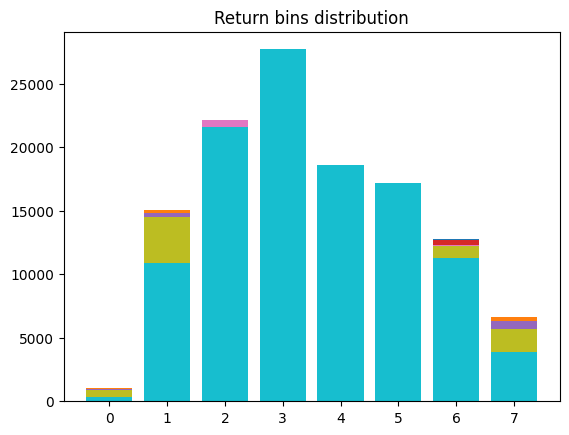

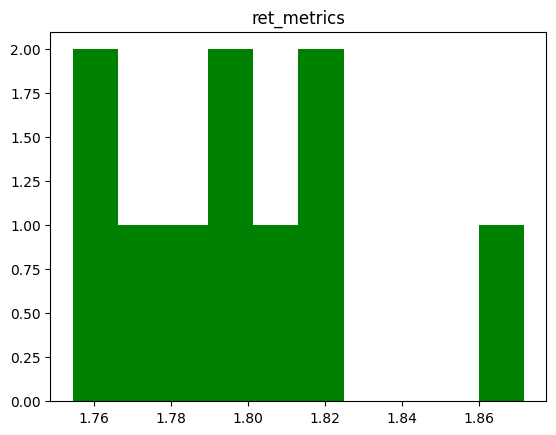

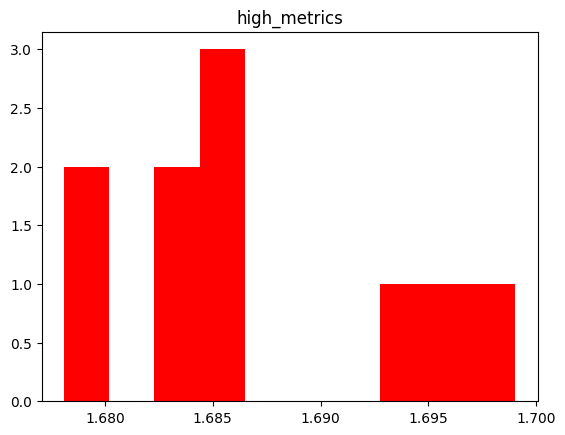

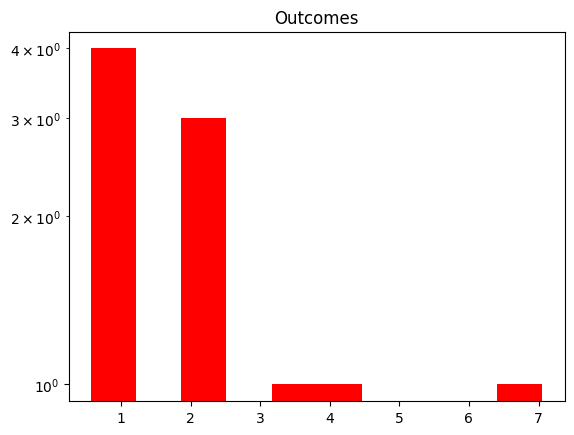

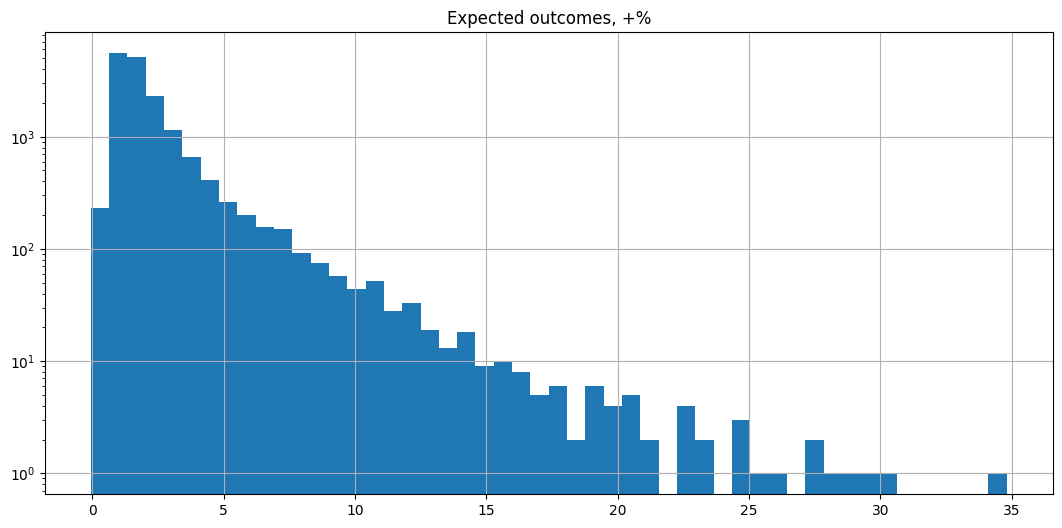

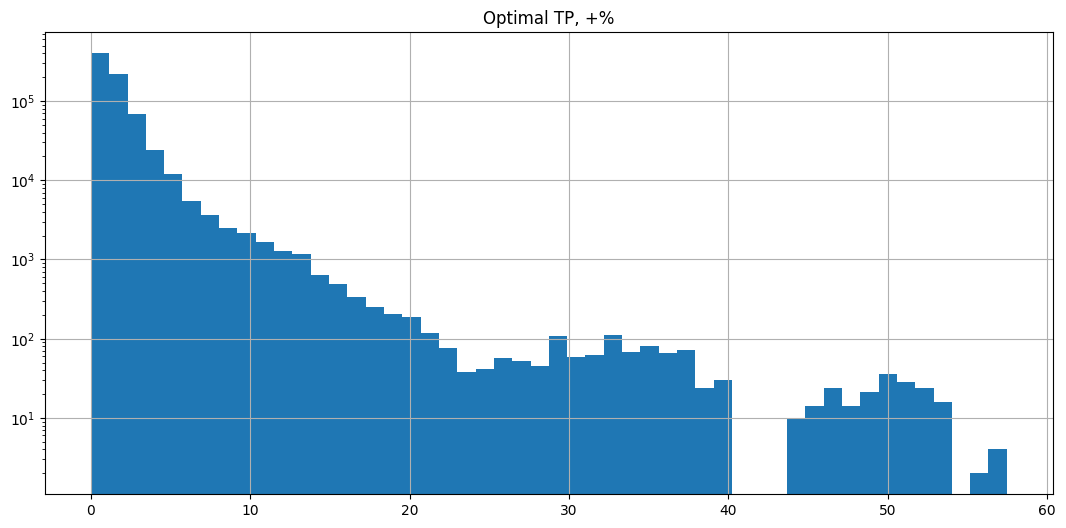

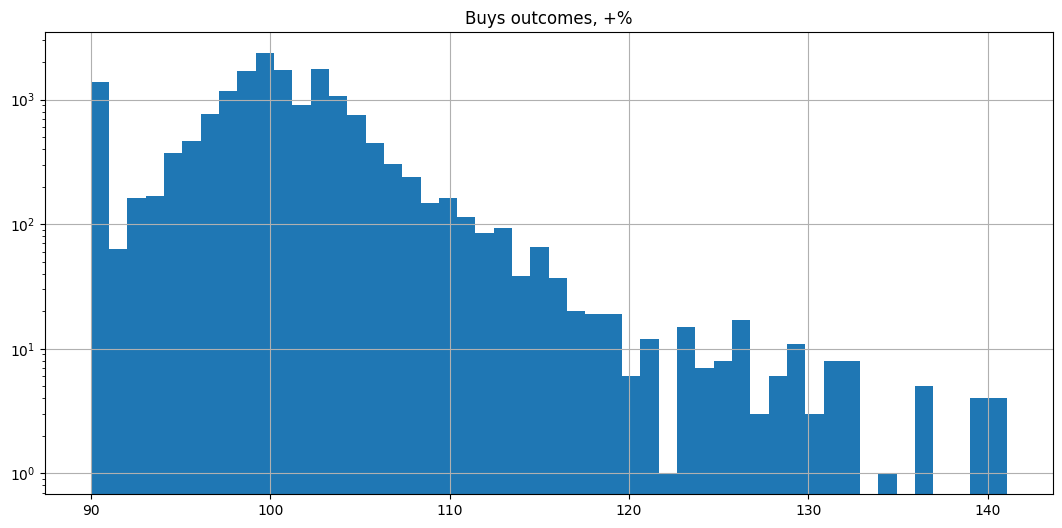

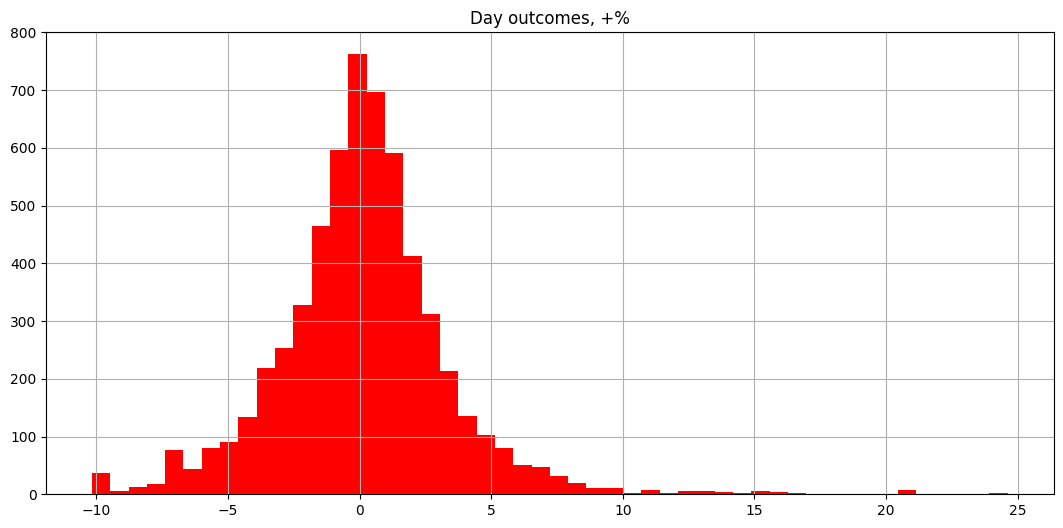

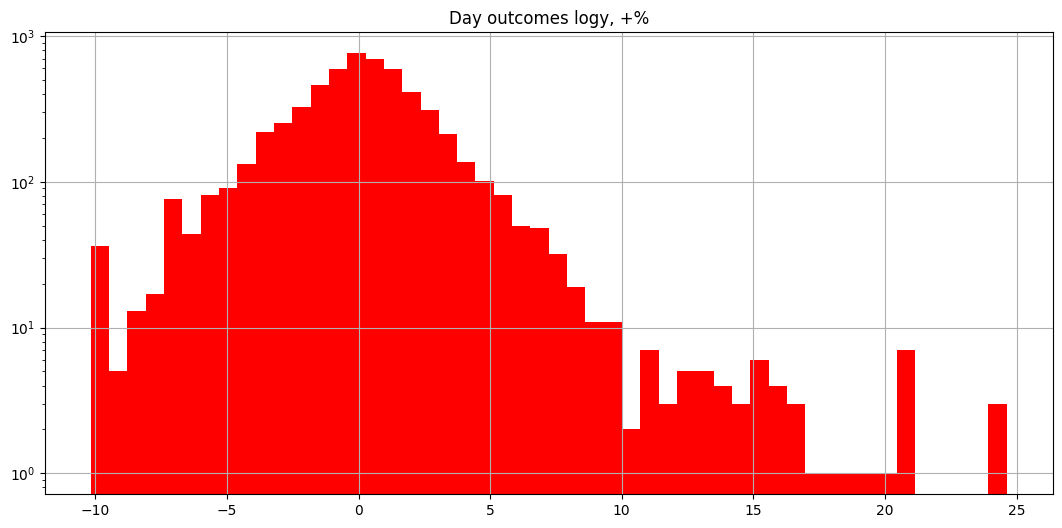

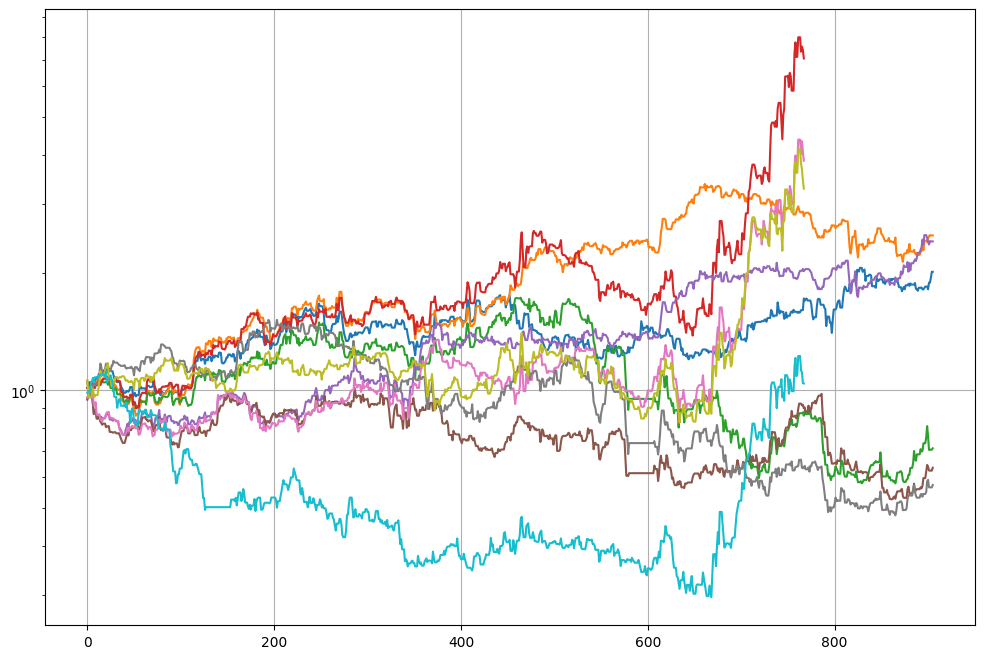

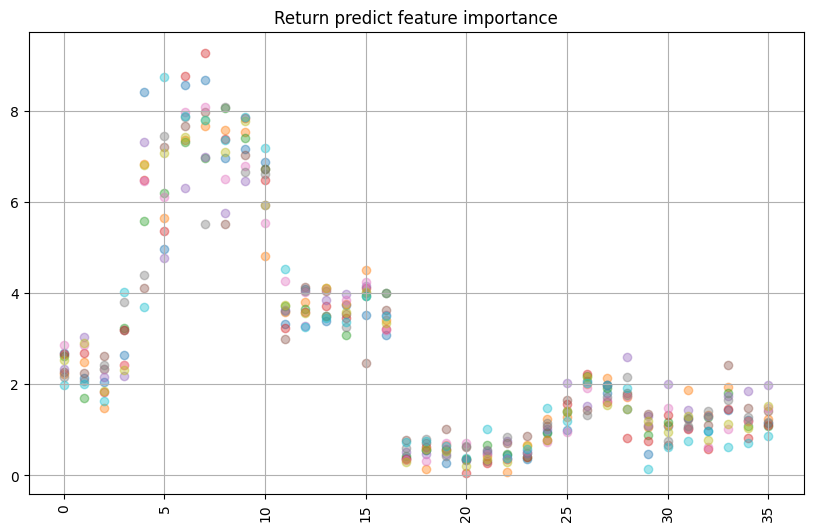

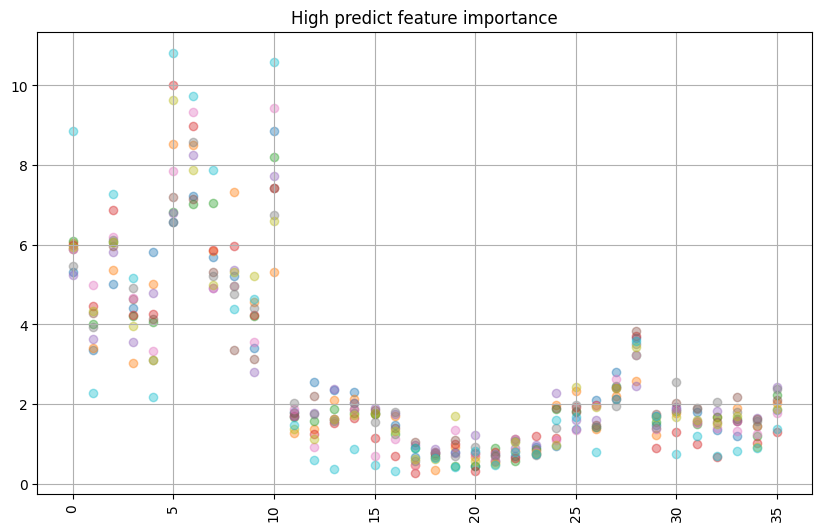

In [9]:
training.currentParams["MaxBuys"] = 3
training.currentParams["BankPart"] = 0.333
training.currentParams["minTakeProfit"] = 0.03

trainInfo = training.runTrain()

### Тестирование полученных моделей на последних днях

In [10]:
dateToXPredFrames, lastDate = feats.createXPredDataset(lastDays=140)

In [11]:
histories = []
stats = {}
for MODEL_NUM in range(10):
  _, newHistory = training.runPredict(dateToXPredFrames, list(dateToXPredFrames.keys()), trainInfo["models"][MODEL_NUM][0], trainInfo["models"][MODEL_NUM][1], stats=stats, verb = 0)
  histories.append(newHistory)

Take Profit amount: 	 494
Stop Loss amount: 	 185
Profit deals amount: 	 854
Loss deals amount: 	 1197
Mean result: 1.209594025369631
IMOEX result: 1.0793004389938308


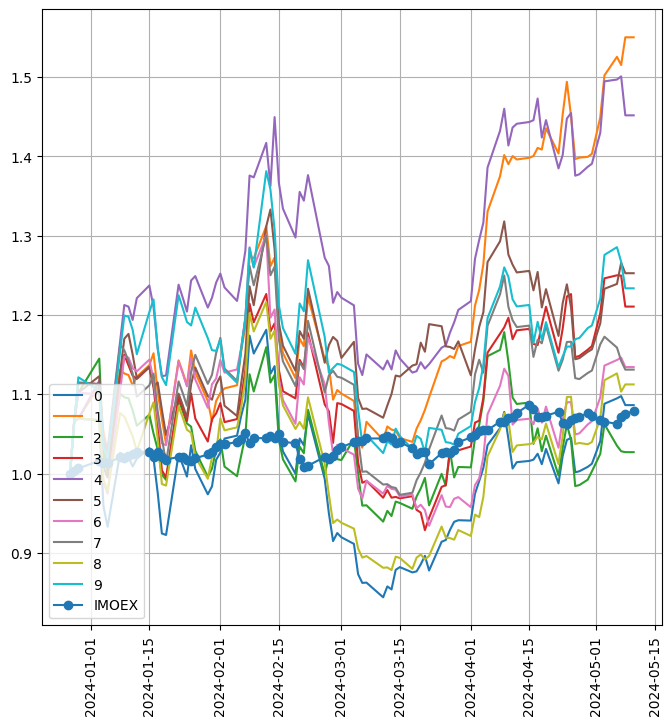

In [12]:
imoexHistory = [1]
imoexDays = list(imoexDayResults.keys())[-(len(histories[0])):]
for i in range(len(histories[0]) - 1):
  day = imoexDays[i+1]
  result = imoexDayResults[day]
  imoexHistory.append(imoexHistory[-1] * result)

print("Take Profit amount: \t", stats["takeProfitsAmount"])
print("Stop Loss amount: \t", stats["stopLossesAmount"])
print("Profit deals amount: \t", stats["profitDealsAmount"])
print("Loss deals amount: \t", stats["lossDealsAmount"])
plt.figure(figsize=(8, 8))
res = 1
for i in range(10):
  plt.plot(imoexDays, histories[i], label = str(i))
  res *= histories[i][-1]
plt.plot(imoexDays, imoexHistory, label = "IMOEX", marker = "o")
plt.legend(loc="lower left")
plt.grid()
print("Mean result:", res**(1/10))
print("IMOEX result:", imoexHistory[-1])
plt.xticks(rotation=90);

Тестирование одной модели с подробным выводом совершаемых действий

{'stopLoss': 0.1, 'TH': -1, 'minTakeProfit': 0.03, 'takeProfitMul': 1.0, 'MaxBuys': 3, 'comission': 0.001, 'BankPart': 0.333, 'partPower': 0, 'highLevels': [0.04, 0.3, 0.5, 0.7, 0.95], 'retLevels': [-0.02, -0.007, 0.001, 0.007, 0.017, 0.04], 'lastTopFrames': 1, 'topPreds': 0.0, 'ITERS': 1200, 'pairProbPow': 0, 'seed': 1}
2023-12-25 +6.57% (1.066)
+16.77% -- Buy GTRK for 427.02, sell for 502.08(+18.16%) Bank part 0.33 Expected result +5.27% Stop Loss 384.32(-10.00%)
+1.57% -- Buy KZIZ for 521.43, sell for 580.66(+11.91%) Bank part 0.33 Expected result +5.20% Stop Loss 469.29(-10.00%)
+2.03% -- Buy UFOSP for 100.50, sell for 106.69(+6.69%) Bank part 0.33 Expected result +3.66% Stop Loss 90.45(-10.00%)


2023-12-26 +0.32% (1.069)
-1.92% -- Buy KZIZ for 529.59, sell for 589.55(+11.88%) Bank part 0.33 Expected result +7.29% Stop Loss 476.64(-10.00%)
-0.04% -- Buy NTZL for 70.87, sell for 79.17(+12.27%) Bank part 0.33 Expected result +4.26% Stop Loss 63.79(-10.00%)
+3.54% -- Buy ZILLP for 25

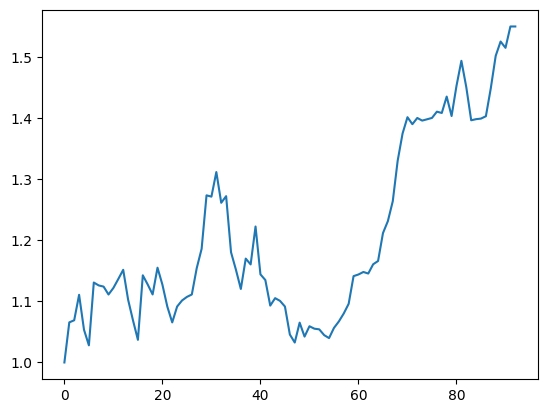

In [13]:
MODEL_NUM = 1
training.runPredict(dateToXPredFrames, list(dateToXPredFrames.keys()), trainInfo["models"][MODEL_NUM][0], trainInfo["models"][MODEL_NUM][1], stats=stats, verb = 1);